# Vaccinazioni

Vaccinazioni in Italia.

> Max Pierini

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
cov = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-latest.csv',
    parse_dates=['data']
)

In [3]:
tot = cov.totale_casi.values[0]

In [4]:
pop = pd.read_csv('pop_16.csv')

In [5]:
eta = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_fasceEta.csv',
    parse_dates=['aggiornamento'],
)

In [6]:
sex = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_sesso.csv',
    parse_dates=['aggiornamento'],
)

In [7]:
cat = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_categoria.csv',
    parse_dates=['aggiornamento'],
)

In [8]:
cat['cat_idx'] = cat.categoria.str.replace('.* - ', '').str.replace(' ', '\n')

In [9]:
reg = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_somministrazioni.csv',
    parse_dates=['aggiornamento'],
)

# Ultimi dati

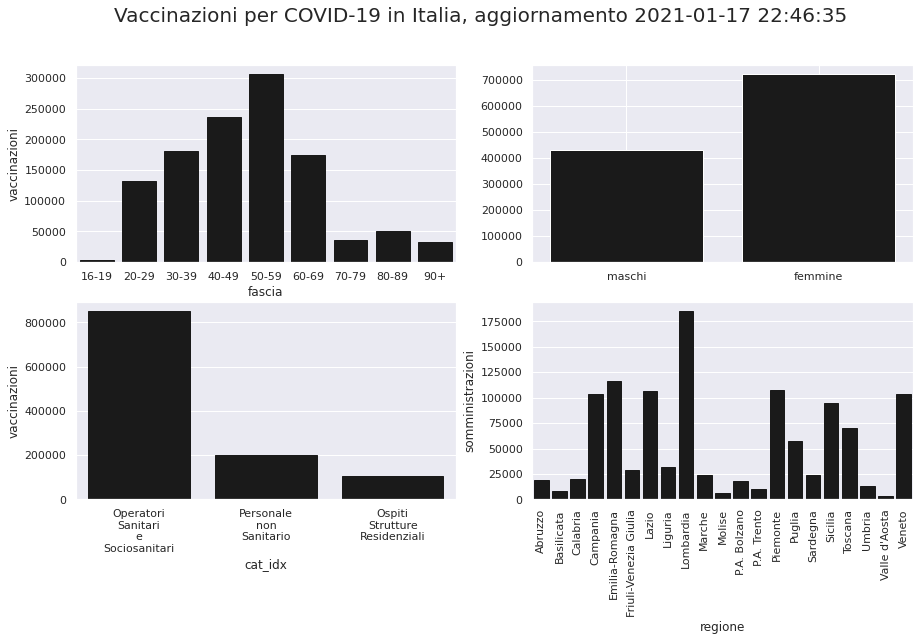

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.barplot(
    data=eta, ax=ax[0,0],
    x='fascia', y='vaccinazioni',
    color='k', ec='k',
)


ax[0,1].bar('maschi', sex.maschi, color='k')
ax[0,1].bar('femmine', sex.femmine, color='k')

sns.barplot(
    data=cat,
    x='cat_idx',
    y='vaccinazioni',
    color='k', ec='k',
    ax=ax[1,0]
)

g = sns.barplot(
    data=reg,
    x='regione',
    y='somministrazioni',
    color='k', ec='k',
    ax=ax[1,1]
)
g.axes.tick_params(axis='x', labelrotation=90)
fig.suptitle(
    f"Vaccinazioni per COVID-19 in Italia, aggiornamento {sex.aggiornamento.max()}",
    fontsize=20,
)
plt.show()

In [11]:
reg_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/somministrazioni.csv',
    parse_dates=['aggiornamento']
)

it_ts = reg_ts.groupby('aggiornamento')[['somministrazioni']].sum()
it_ts.loc[pd.to_datetime('2020-12-28'), 'somministrazioni'] = 0
it_ts.loc[pd.to_datetime('2020-12-29'), 'somministrazioni'] = 8361
it_ts.loc[pd.to_datetime('2020-12-30'), 'somministrazioni'] = 9803
it_ts.loc[pd.to_datetime('2020-12-31'), 'somministrazioni'] = 22789
it_ts.loc[pd.to_datetime('2021-01-01'), 'somministrazioni'] = 45667

for regione in reg_ts.regione.unique():
    reg_ts = reg_ts.append(
        pd.DataFrame({
            'regione': [regione],
            'somministrazioni': [0],
            'percentuale': [0.0],
            'dosiConsegnate': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )
it_ts.sort_index(inplace=True)

In [12]:
it_ts_day = it_ts.resample('D').max()

# Totali

In [13]:
popolazione_italia = pop[pop.regione=='Italia'].popolazione.values[0]

In [14]:
pop_it = popolazione_italia - tot

In [15]:
Markdown(fr"""
Popolazione italiana maggiore di 16 anni (al 1° gennaio 2020, dati ISTAT)

$$
\mathbf{{pop}}_{{it}} = {f"{popolazione_italia:,}".replace(",", "'")} \textrm{{ persone}}
$$

definendo i soggetti suscettibili **S**
escludendo i casi totali di COVID-19 osservati finora

$$
\mathbf{{S}}_{{it}} = \mathbf{{pop}}_{{it}} - \mathbf{{COVID}}_{{it}} =
{f"{popolazione_italia:,}".replace(",", "'")} - {f"{tot:,}".replace(",", "'")} = 
{f"{pop_it:,}".replace(",", "'")} \textrm{{ persone}}
$$
""")


Popolazione italiana maggiore di 16 anni (al 1° gennaio 2020, dati ISTAT)

$$
\mathbf{pop}_{it} = 51'341'724 \textrm{ persone}
$$

definendo i soggetti suscettibili **S**
escludendo i casi totali di COVID-19 osservati finora

$$
\mathbf{S}_{it} = \mathbf{pop}_{it} - \mathbf{COVID}_{it} =
51'341'724 - 2'390'101 = 
48'951'623 \textrm{ persone}
$$


In [16]:
E = .95
R0 = 3
HIT = 1 - 1 / R0
V = HIT / E
V_it = V * pop_it
HIT_it = HIT * pop_it
VAX = it_ts.somministrazioni.values[-1]
VAX_pct = VAX / pop_it

Markdown(fr"""
Soglia immunità di gregge **HIT** per COVID-19, considerando
$R_0={R0}$

$$
\mathbf{{HIT}} = 1 - \frac{{1}}{{R_0}} = {HIT * 100:.0f}\%
$$

Soglia considerando la popolazione suscettibile dai 16 anni

$$
\mathbf{{HIT}}_{{it}} = \mathbf{{HIT}} \cdot \mathbf{{S}}_{{it}} = 
{f"{HIT_it:,.0f}".replace(",", "'")} \textrm{{ abitanti}}
$$

Data l'efficacia vaccinale **E** del {E:.0%}
la minima copertura vaccinale **V** da raggiungere
è pari a

$$
\mathbf{{V}} = \frac{{ \mathbf{{HIT}} }}{{ \mathbf{{E}} }} = 
\frac{{{HIT:.2f}}}{{{E:.2f}}} = {V*100:.0f}\%
$$

pertanto, la soglia per immunità di gregge in italia considerando
l'efficacia vaccinale risulta

$$
\mathbf{{V}}_{{it}} = \mathbf{{V}} \cdot \mathbf{{S}}_{{it}} = 
{f"{V_it:,.0f}".replace(",", "'")} \textrm{{ abitanti}}
$$

***

Attuale numero di vaccini somministrati

$$
\mathbf{{VAX}} = {f"{VAX:,.0f}".replace(",", "'")} \textrm{{ vaccini}}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{{VAX}}\% = \frac{{ \mathbf{{VAX}} }}{{ \mathbf{{S}}_{{it}} }} =
{VAX_pct * 100:.2f}\%
$$""")


Soglia immunità di gregge **HIT** per COVID-19, considerando
$R_0=3$

$$
\mathbf{HIT} = 1 - \frac{1}{R_0} = 67\%
$$

Soglia considerando la popolazione suscettibile dai 16 anni

$$
\mathbf{HIT}_{it} = \mathbf{HIT} \cdot \mathbf{S}_{it} = 
32'634'415 \textrm{ abitanti}
$$

Data l'efficacia vaccinale **E** del 95%
la minima copertura vaccinale **V** da raggiungere
è pari a

$$
\mathbf{V} = \frac{ \mathbf{HIT} }{ \mathbf{E} } = 
\frac{0.67}{0.95} = 70\%
$$

pertanto, la soglia per immunità di gregge in italia considerando
l'efficacia vaccinale risulta

$$
\mathbf{V}_{it} = \mathbf{V} \cdot \mathbf{S}_{it} = 
34'352'016 \textrm{ abitanti}
$$

***

Attuale numero di vaccini somministrati

$$
\mathbf{VAX} = 1'153'501 \textrm{ vaccini}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{VAX}\% = \frac{ \mathbf{VAX} }{ \mathbf{S}_{it} } =
2.36\%
$$

In [17]:
#VAX_n = VAX / it_ts.resample('D').max().index.size
#VAX_n = it_ts.diff()[-7:].values.mean()

In [18]:
vax_Y = it_ts_day[-7:].values.ravel()
vax_X = np.arange(vax_Y.size)
vax_X = sm.add_constant(vax_X)
mod = sm.OLS(vax_Y, vax_X)
res = mod.fit()
VAX_n = res.params[1]
vax_i = res.params[0]

In [19]:
VAX_pred = vax_i + np.arange(14) * VAX_n

In [20]:
pred_dates = pd.date_range(
    it_ts_day.index[-6].date(),
    it_ts_day.index[-6] + pd.Timedelta(days=13),
)

In [21]:
HIT_rem = V_it - VAX

In [22]:
REM_d = HIT_rem / VAX_n

In [23]:
Markdown(fr"""
Vaccini somministrati mediamente al giorno $n$ nell'ultima settimana
(regressione lineare)

$$
\mathbf{{VAX}}_{{n}} = \frac{{\mathbf{{VAX}}}}{{\mathrm{{giorni}}}} \simeq 
{f"{VAX_n:,.0f}".replace(",", "'")} 
\textrm{{ vaccini al giorno }}
$$

Vaccini restanti da somministrare per raggiungere la soglia **V**
(**HIT** considerando l'efficacia vaccinale **E**)

$$
\mathbf{{VAX}}_{{rem}} = \mathbf{{V}}_{{it}} - \mathbf{{VAX}} = 
{f"{HIT_rem:,.0f}".replace(",", "'")}
\textrm{{ abitanti}}
$$

Tempo stimato per raggiungimento della soglia vaccinale **V** al ritmo 
di somministrazione attuale

$$
\mathbf{{T}}_{{rem}} = \frac{{\mathbf{{VAX}}_{{rem}}}}{{\mathbf{{VAX}}_{{n}}}} =
{f"{REM_d:,.0f}".replace(",", "'")} \textrm{{ giorni}}
= {REM_d/365*12:,.0f} \textrm{{ mesi}}
= {REM_d/365:,.1f} \textrm{{ anni}}
$$
""")


Vaccini somministrati mediamente al giorno $n$ nell'ultima settimana
(regressione lineare)

$$
\mathbf{VAX}_{n} = \frac{\mathbf{VAX}}{\mathrm{giorni}} \simeq 
75'888 
\textrm{ vaccini al giorno }
$$

Vaccini restanti da somministrare per raggiungere la soglia **V**
(**HIT** considerando l'efficacia vaccinale **E**)

$$
\mathbf{VAX}_{rem} = \mathbf{V}_{it} - \mathbf{VAX} = 
33'198'515
\textrm{ abitanti}
$$

Tempo stimato per raggiungimento della soglia vaccinale **V** al ritmo 
di somministrazione attuale

$$
\mathbf{T}_{rem} = \frac{\mathbf{VAX}_{rem}}{\mathbf{VAX}_{n}} =
437 \textrm{ giorni}
= 14 \textrm{ mesi}
= 1.2 \textrm{ anni}
$$


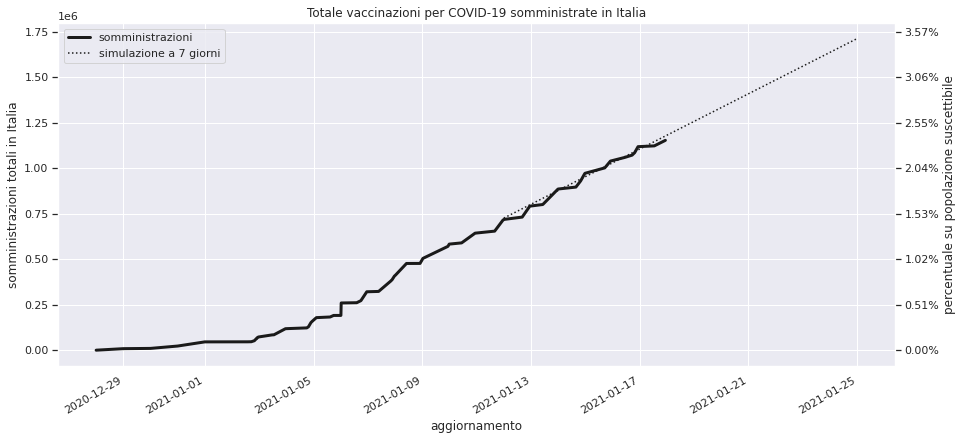

In [24]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
it_ts.plot(
    y='somministrazioni',
    title='Totale vaccinazioni per COVID-19 somministrate in Italia',
    #marker='.', 
    color='k', lw=3,
    legend=False,
    ax=ax
)

ax.plot(pred_dates, VAX_pred, ls=':', color='k', label='simulazione a 7 giorni')

ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.2%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione suscettibile'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

ax.legend()

plt.show()

In [25]:
HIT_pred_dates = pd.date_range(
    it_ts_day.index[-6],
    it_ts_day.index[-6] + pd.Timedelta(days=REM_d+6),
)

In [26]:
HIT_pred = vax_i + VAX_n * np.arange(HIT_pred_dates.size)

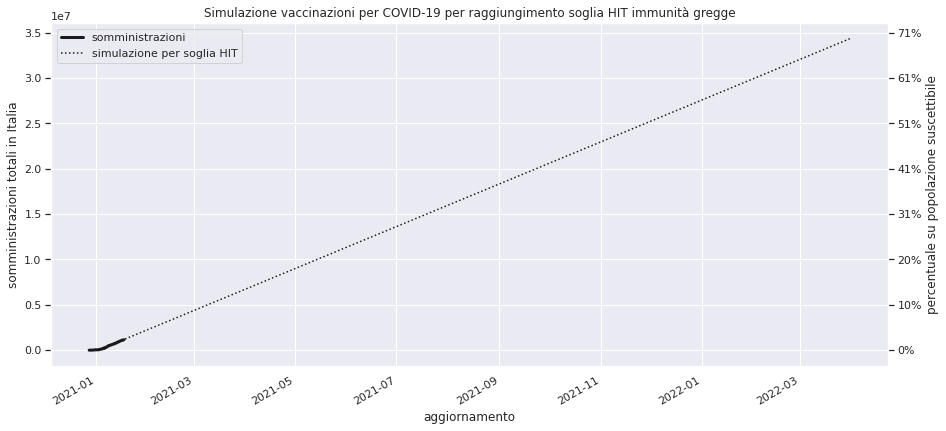

In [27]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
it_ts.plot(
    y='somministrazioni',
    title='Simulazione vaccinazioni per COVID-19 per raggiungimento soglia HIT immunità gregge',
    #marker='.', 
    color='k', lw=3,
    legend=False,
    ax=ax
)

ax.plot(HIT_pred_dates, HIT_pred, ls=':', color='k', label='simulazione per soglia HIT')

ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.0%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione suscettibile'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

ax.legend()

plt.show()

# Regioni

In [28]:
pop.regione = pop.regione.str.replace("Valle d'Aosta / Vallée d'Aoste", "Valle d'Aosta")

In [29]:
pop.regione = pop.regione.str.replace("Provincia Autonoma Bolzano / Bozen", "P.A. Bolzano")

In [30]:
pop.regione = pop.regione.str.replace("Provincia Autonoma Trento", "P.A. Trento")

In [31]:
pop.regione = pop.regione.str.replace("Friuli-Venezia Giulia", "Friuli-Venezia-Giulia")

In [32]:
reg = reg.merge(
    pop,
    on='regione'
)

In [33]:
reg['percentuale su popolazione'] = reg.somministrazioni / reg.popolazione

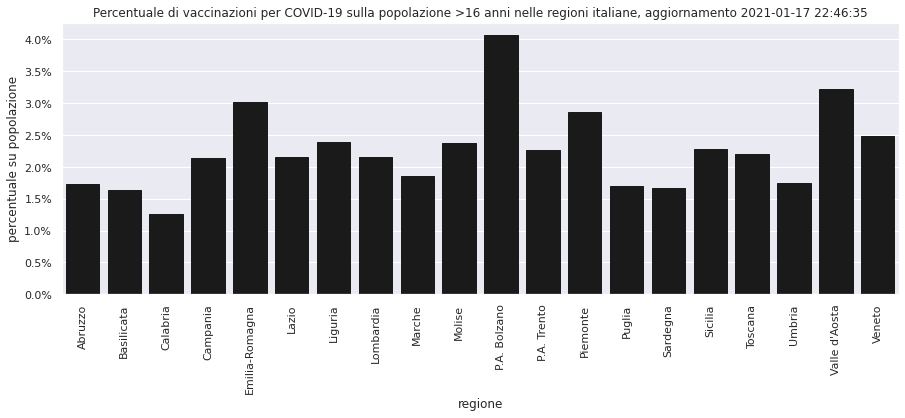

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=reg,
    x='regione',
    y='percentuale su popolazione',
    color='k', ec='k',
    ax=ax
)
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
ax.set(
    title=f"Percentuale di vaccinazioni per COVID-19 sulla popolazione >16 anni nelle regioni italiane, aggiornamento {sex.aggiornamento.max()}",
)
plt.show()

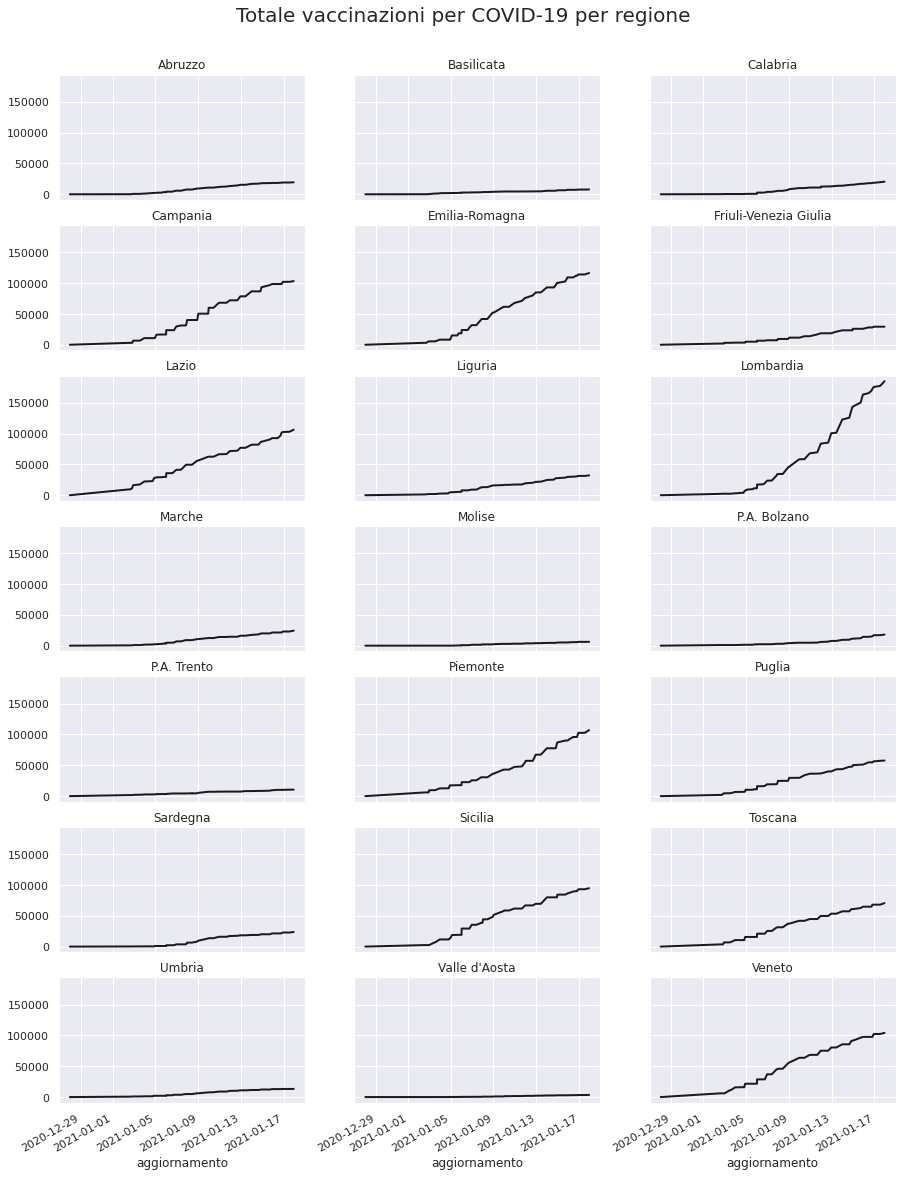

In [35]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg_ts.regione.unique()):
    _ts = reg_ts[reg_ts.regione==regione]
    _ts.plot(
        x='aggiornamento', y='somministrazioni', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
fig.suptitle("Totale vaccinazioni per COVID-19 per regione", fontsize=20, y=.925)
plt.show()

# Età

In [36]:
eta_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/fasceEta.csv',
    parse_dates=['aggiornamento'],
)

In [37]:
for fascia in eta_ts.fascia.unique():
    eta_ts = eta_ts.append(
        pd.DataFrame({
            'fascia': [fascia],
            'vaccinazioni': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )

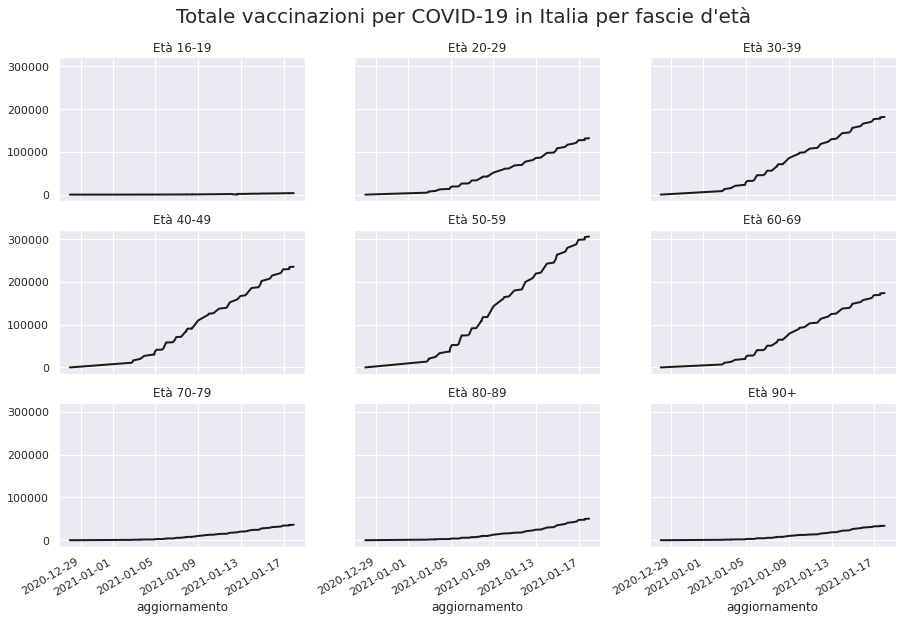

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
for i, fascia in enumerate(eta_ts.fascia.unique()[:-1]):
    fascia_name = fascia
    if fascia == '16-19':
        _ts = eta_ts[(eta_ts.fascia==fascia)|(eta_ts.fascia=='<=15')]
        #fascia_name = '<=15 e 16-19'
    else:
        _ts = eta_ts[(eta_ts.fascia==fascia)]
    _ts.plot(
        x='aggiornamento', y='vaccinazioni', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, 
        legend=False,
        title=f'Età {fascia_name}'
    )
fig.suptitle("Totale vaccinazioni per COVID-19 in Italia per fascie d'età", fontsize=20, y=.95)
plt.show()

In [39]:
sex_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/sesso.csv',
    parse_dates=['aggiornamento']
)

In [40]:
sex_ts = sex_ts.append(
    pd.DataFrame({
        'maschi': [0],
        'femmine': [0],
        'aggiornamento': [pd.to_datetime('2020-12-28')]
    })
)

# Sesso

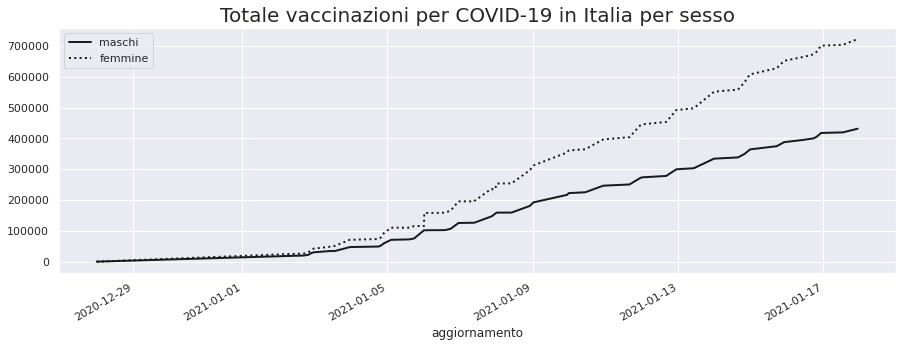

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
sex_ts.plot(
    x='aggiornamento', y='maschi',
    #marker='.', ms=2,
    color='k', lw=2, ls='-',
    ax=ax
)
sex_ts.plot(
    x='aggiornamento', y='femmine',
    #marker='.',  ms=2,
    color='k', lw=2, ls=':',
    ax=ax
)
ax.set_title("Totale vaccinazioni per COVID-19 in Italia per sesso", fontsize=20)
plt.show()

In [42]:
cat_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/categoria.csv',
    parse_dates=['aggiornamento']
)

In [43]:
for categoria in cat_ts.categoria.unique():
    cat_ts = cat_ts.append(
        pd.DataFrame({
            'categoria': [categoria],
            'vaccinazioni': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )

# Categoria

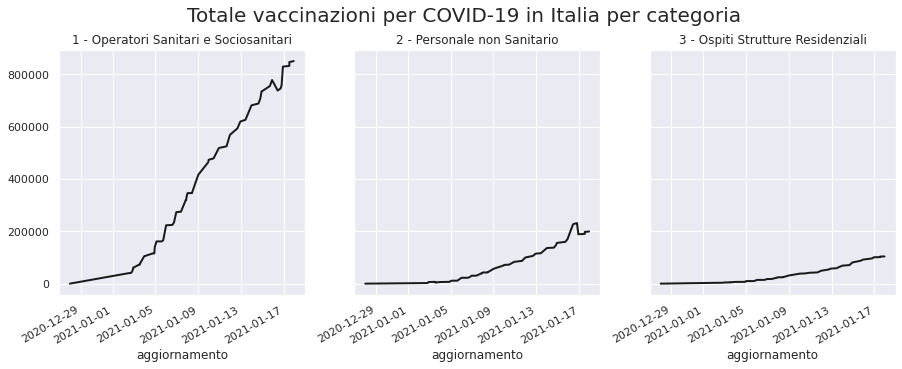

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i, categoria in enumerate(cat_ts.categoria.unique()):
    _ts = cat_ts[cat_ts.categoria==categoria]
    _ts.plot(
        x='aggiornamento', y='vaccinazioni', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, 
        legend=False,
        title=f"{categoria}"
    )
ylim = ax.flat[0].get_ylim()
#ax.flat[0].set(
#    ylim=(0, ylim[1])
#)
fig.suptitle("Totale vaccinazioni per COVID-19 in Italia per categoria", fontsize=20, y=1)
plt.show()